In [1]:
!pip install japanize-matplotlib | tail -n 1
!pip install torchviz | tail -1
!pip install torchinfo | tail -n 1

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def eval_loss(loader, device, net, criterion):
    images, labels = next(iter(loader))
    inputs = images.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return loss

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        net.train()
        count = 0
        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum().item()
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        net.eval()
        count = 0
        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            val_acc += (predicted == labels).sum().item()
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print(f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

def evaluate_history(history):
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )
    num_epochs = len(history)
    if num_epochs < 10:
        unit = 1
    else:
        unit = num_epochs / 10
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

def show_images_labels(loader, classes, net, device):
    images, labels = next(iter(loader))
    n_size = min(len(images), 50)
    if net is not None:
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        if net is not None:
            predicted_name = classes[predicted[i]]
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'r'
            ax.set_title(label_name[:4] + ':' + predicted_name[:4], c=c, fontsize=20)
        else:
            ax.set_title(label_name, fontsize=20)
        image_np = images[i].numpy().copy()
        img = np.transpose(image_np, (1, 2, 0))
        img = (img + 1)/2
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

cuda:0


In [2]:
import shutil

fname = 'cats.zip'
shutil.unpack_archive(fname, './')

In [3]:
import os

data_dir = 'cats'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
classes = ['british_shorthair', 'main_coon', 'ragdoll', 'scottish_fold']

<class 'PIL.Image.Image'>
(640, 427)


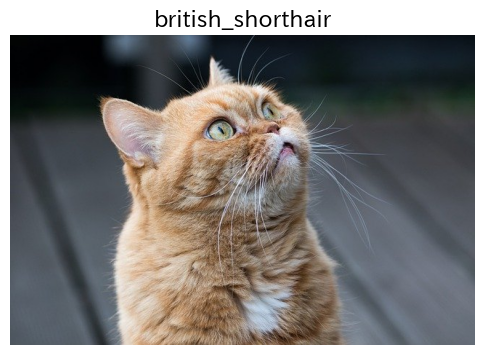

In [4]:
dataset = datasets.ImageFolder(root='./cats')
image, label = dataset[0]
print(type(image))
print(image.size)
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

print(f'訓練データ1: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')


訓練データ1: 36件
検証データ: 9件


In [15]:
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)

In [16]:
from torchvision import models

net = models.densenet201(pretrained = True)
print(net)
print(summary)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.36998 acc: 0.16667 val_loss: 0.45361, val_acc: 0.33333


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.35990 acc: 0.27778 val_loss: 0.41147, val_acc: 0.55556


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.29719 acc: 0.52778 val_loss: 0.36870, val_acc: 0.33333


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.23103 acc: 0.61111 val_loss: 0.35839, val_acc: 0.77778


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.32512 acc: 0.55556 val_loss: 0.39808, val_acc: 0.55556


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.25065 acc: 0.58333 val_loss: 0.26587, val_acc: 0.44444


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.16284 acc: 0.83333 val_loss: 0.24321, val_acc: 1.00000


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.15545 acc: 0.86111 val_loss: 0.21499, val_acc: 1.00000


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.19425 acc: 0.66667 val_loss: 0.18074, val_acc: 1.00000


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.14023 acc: 0.77778 val_loss: 0.15920, val_acc: 1.00000
初期状態: 損失: 0.45361 精度: 0.33333
最終状態: 損失: 0.15920 精度: 1.00000


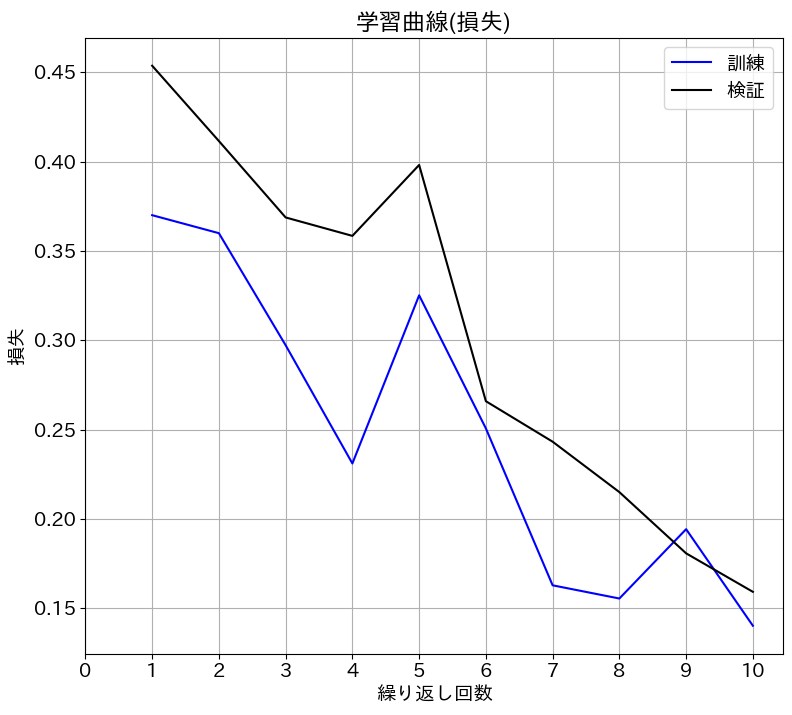

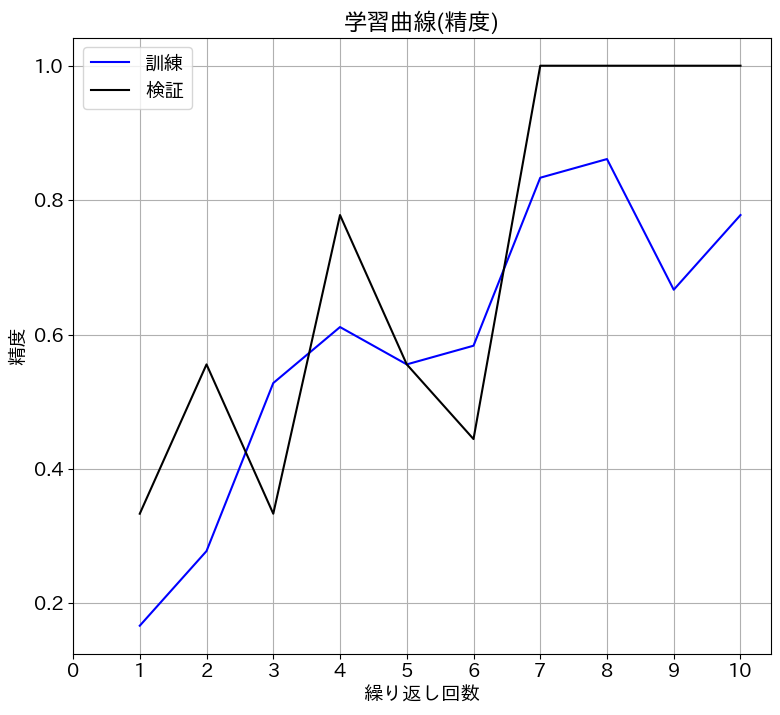

In [17]:
for param in net.parameters():
    param.requires_grad = False

torch_seed(36)

in_features = net.classifier.in_features
net.classifier = nn.Linear(in_features, len(classes))
net.avgpool = nn.Identity()
net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.classifier.parameters(),lr=lr,momentum=0.9)
history = np.zeros((0, 5))
num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)
evaluate_history(history)

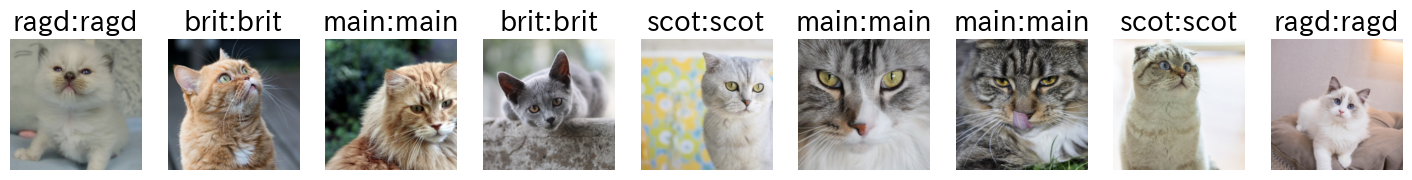

In [18]:
show_images_labels(test_loader2, classes, net, device)